In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My\ Drive/Colab\ Notebooks

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


In [0]:
# !wget 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar' 
# !tar -xf VOCtrainval_06-Nov-2007.tar
# !wget 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar'  
# !tar -xf VOCtest_06-Nov-2007.tar

# Assignment 3

# Instructions

1. You have to use only this notebook for all your code.
2. All the results and plots should be mentioned in this notebook.
3. For final submission, submit this notebook along with the report ( usual 2-4 pages, latex typeset, which includes the challenges faces and details of additional steps, if any)
4. Marking scheme
    -  **60%**: Your code should be able to detect bounding boxes using resnet 18, correct data loading and preprocessing. Plot any 5 correct and 5 incorrect sample detections from the test set in this notebook for both the approached (1 layer and 2 layer detection), so total of 20 plots.
    -  **20%**: Use two layers (multi-scale feature maps) to detect objects independently as in SSD (https://arxiv.org/abs/1512.02325).  In this method, 1st detection will be through the last layer of Resnet18 and the 2nd detection could be through any layer before the last layer. SSD uses lower resolution layers to detect larger scale objects. 
    -  **20%**: Implement Non-maximum suppression (NMS) (should not be imported from any library) on the candidate bounding boxes.
    
5. Report AP for each of the three class and mAP score for the complete test set.

In [0]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.utils.data
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import time

from torchvision import datasets, transforms, models
import time
import os
num_classes = 4
input_size = 224

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Build the data
Use the following links to locally download the data:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>The dataset consists of images from 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, i.e. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the three classes(aeroplane, bottle, chair). For parsing the xml file, you can import xml.etree.ElementTree for you. <br/>
<br/> Organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be four. This is important for applying the sliding window method later.


In [0]:
import xml.etree.ElementTree as ET
import cv2
import random
import matplotlib.pyplot as plt
import os
import numpy as np

classes = ['__background__','aeroplane','bottle','chair']
wSide=[32,64,128,256]

In [0]:
# Function to read XML file annotations
def read_content(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    list_with_all_boxes = []
    for boxes in root.iter('object'):
        ymin, xmin, ymax, xmax = None, None, None, None
        n = boxes.find("name").text
        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)
        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append((n,list_with_single_boxes))
        
    for box in root.findall('size'):
        h = int(box.find('height').text)
        w = int(box.find('width').text)        
    return ((h,w),list_with_all_boxes)
  
# Function to find IoU 
def bb_iou(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union 
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou  

In [0]:
# Function to return background BB when given object BB
# This will randomly sample a background patch from the remaining area in the image
def getBGbb(size,blist):
  searchIter=0
  while True:
    #randomly pick patch side length
    wSideIdx=random.randint(0,3)
    #randomly pick patch aspect ratio
    wAsp=random.randint(0,2)
    if wAsp==0:
      w_height=wSide[wSideIdx]
      w_width=w_height
    elif wAsp==1:
      w_height=wSide[wSideIdx]
      w_width=2*w_height
    elif wAsp==2:
      w_width=wSide[wSideIdx]
      w_height=2*w_width
    bglist=[]
    #slide patch through the image and pick first patch which does not overlap with an object
    for i in range(size[0]//w_height):
        for j in range(size[1]//w_width):
            box = (j*w_width, i*w_height, (j+1)*w_width, (i+1)*w_height)
            allowed=1
    #         print(box,objBox,bb_iou(box,objBox))
            for objBox in blist:
              if bb_iou(box,objBox)!=0:              
                  allowed=0
            if allowed==1:
              bglist.append(box)
            if len(bglist)==1:
#             ==len(blist):
              break
        if len(bglist)==1:
#     ==len(blist):
            break          
#     print(bglist,blist)   
    searchIter+=1
    if len(bglist)==1 or searchIter>=10:
#     ==len(blist) or searchIter>=10:
        return bglist

# print(getBGbb(blist),blist)    

In [0]:
# Function to build dataset
def build_dataset():
  #find out which files contain aeroplane,bottle and chair
  xmlfilesdata = np.loadtxt('VOCdevkit/VOC2007/ImageSets/Main/aeroplane_val.txt',dtype='str')
  id = (xmlfilesdata[:,1].astype(np.int))
  xmlfiles1 = xmlfilesdata[np.where(id>=1),0][0]
  xmlfilesdata = np.loadtxt('VOCdevkit/VOC2007/ImageSets/Main/bottle_val.txt',dtype='str')
  id = (xmlfilesdata[:,1].astype(np.int))
  xmlfiles2 = xmlfilesdata[np.where(id>=1),0][0]
  xmlfilesdata = np.loadtxt('VOCdevkit/VOC2007/ImageSets/Main/chair_val.txt',dtype='str')
  id = (xmlfilesdata[:,1].astype(np.int))
  xmlfiles3 = xmlfilesdata[np.where(id>=1),0][0]
  xmlfiles = np.concatenate((xmlfiles1,xmlfiles2,xmlfiles3))

#   for c_dirs in classes:
#     try:
#       os.makedirs(c_dirs)
#     except:
#       print('directory {} already exists'.format(c_dirs))

  nimg=0
  for fname in xmlfiles:
      size,boxes = read_content('VOCdevkit/VOC2007/Annotations/'+str(fname)+'.xml')
      img = cv2.imread('VOCdevkit/VOC2007/JPEGImages/'+str(fname)+'.jpg')
      blist=[]
      # bgFindImg = np.ones((size[0],size[1]))    
      for box in boxes:
        if box[0] in ['aeroplane','chair','bottle']:        
          loc=box[1]
          blist.append(loc)
          objImg=img[loc[1]:loc[3],loc[0]:loc[2],:]
          cv2.imwrite('data2/val/'+box[0]+'/'+str(nimg)+'.jpg',objImg)
          nimg+=1
      bglist = getBGbb(size,blist)
      if len(bglist)>=1:
        for loc in bglist:
          objImg=img[loc[1]:loc[3],loc[0]:loc[2],:]
          cv2.imwrite('data2/val/'+'__background__'+'/'+str(nimg)+'.jpg',objImg)
          nimg+=1

build_dataset()

## Train the netwok
<br/>You can train the network on the created dataset. This will yield a classification network on the 4 classes of the VOC dataset. 

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
 
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [0]:
#load data
batch_size = 50
data_dir='./data2'
input_size = 224
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}


Initializing Datasets and Dataloaders...


### Fine-tuning model 1

In [0]:
feature_extract = False
use_pretrained = True

resnet18 = models.resnet18(pretrained=use_pretrained)
# set_parameter_requires_grad(resnet18, feature_extract)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, num_classes)
# print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 78083919.11it/s]


In [0]:
# resnet18 = models.resnet18(pretrained=True)
#freeze layers
ct = 0
for child in resnet18.children():
  ct += 1
  if ct < 8:
      for param in child.parameters():
          param.requires_grad = False

In [0]:
# Send the model to GPU
resnet18 = resnet18.to(device)

params_to_update = resnet18.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in resnet18.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in resnet18.named_parameters():
        if param.requires_grad == True:
          print("\t",name)

# Observe that all parameters are being optimized
#optimizer = optim.SGD(params_to_update, learning_rate=0.001, momentum=0.9)
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()


In [0]:
import copy
# Train and evaluate
model_name = "resnet"
resnet18, hist = train_model(resnet18, dataloaders_dict, criterion, optimizer_ft, num_epochs=100)

In [0]:
#save the model
c_dirs='model'
try:
  os.makedirs(c_dirs)
except:
  print('directory {} already exists'.format(c_dirs))
torch.save(resnet18, 'model/resnetFCnLastmodel')

directory model already exists


### Fine-tuning model 2


In [0]:
import torch.nn as nn
import torch
class resnet_2layer(nn.Module):
  def __init__(self):
    super(resnet_2layer,self).__init__()
    resnet18 = torch.load('model/resnetFCnLastmodel')
#     resnet18 = models.resnet18(pretrained=True)
    child = []
    for i in resnet18.children():
      child.append(i)

    self.Conv1 = child[0]  # 3->64
    self.bn1 = child[1]
    self.relu = child[2]
    self.maxpool = child[3]
    self.basic1 = child[4]  # 64->64
    self.basic2 = child[5] # 64->128
    self.basic3 = child[6]  # 128->256
    self.avgpool1 = nn.AdaptiveAvgPool2d((1, 1))
    self.avgpool2 = nn.AdaptiveAvgPool2d((1, 1))
    self.fc3 = nn.Linear(256 , 4)

  def forward(self,x):
    x = self.Conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.basic1(x)    
    x = self.basic2(x)
    x = self.basic3(x)
    x = self.avgpool1(x)
    x = x.view(x.size(0), -1)
    x = self.fc3(x)        
    return x
resnet2=resnet_2layer()  

In [0]:
# child_counter = 0
# for i in resnet2.children():
#    print(" child", child_counter, "is:")
#    print(i)
#    child_counter += 1

In [0]:
#Freeze Layers
ct = 0
for child in resnet2.children():
  ct += 1
  if ct < 7:
      for param in child.parameters():
          param.requires_grad = False

In [0]:
# Send the model to GPU
resnet2 = resnet2.to(device)
feature_extract = False
params_to_update = resnet2.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in resnet2.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in resnet2.named_parameters():
        if param.requires_grad == True:
          print("\t",name)

# Observe that all parameters are being optimized
#optimizer = optim.SGD(params_to_update, learning_rate=0.001, momentum=0.9)
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()


Params to learn:
	 fc3.weight
	 fc3.bias


In [0]:
# # # !pip install torchsummary 
# from torchsummary import summary
# summary(resnet2, (3, 224, 224))

In [0]:
import copy
# Train and evaluate
model_name = "resnet"
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# resnet182 = torch.load('model/resnetFCnLastmodel')
resnet2, hist = train_model(resnet2, dataloaders_dict, criterion, optimizer_ft, num_epochs=100)

In [0]:
#save the model
c_dirs='model'
try:
  os.makedirs(c_dirs)
except:
  print('directory {} already exists'.format(c_dirs))
torch.save(resnet2, 'model/resnet2model')

directory model already exists


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type resnet_2layer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Testing and Accuracy Calculation
For applying detection, use a slding window method to test the above trained trained network on the detection task:<br/>
Take some windows of varying size and aspect ratios and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value. There is a similar approach used in the paper -Faster RCNN by Ross Girshick, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide. You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [0]:
resnet18 = torch.load('model/resnetFCnLastmodel')
# resnet2 = torch.load('model/resnet_123layer')
resnet2 = torch.load('model/resnet2model')

resnet18.eval();
resnet2.eval();

imsize = input_size;
loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()]);
 
def img2Tensor(image):
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image.cuda()  
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)  

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [0]:
#predict using model 1
def pred_obj1(img):
  wSide=[32,64,128,256]

  w,h=img.size
  size=[h,w]
  boxPredList1=[]
  boxPredList2=[]
  boxPredList3=[]

  # def getBGbb(blist):
  for wSideCurr in wSide:
    for wAsp in range(3):
      if wAsp==0:#1:1
        w_height=wSideCurr
        w_width=w_height
      elif wAsp==1:#1:2
        w_height=wSideCurr
        w_width=2*w_height
      elif wAsp==2:#2:1
        w_width=wSideCurr
        w_height=2*w_width
      for i in np.arange(0,(size[0]//(w_height))+1,0.5):
          for j in np.arange(0,(size[1]//(w_width))+1,0.5):
              xmin=j*w_width
              if xmin>size[1]:
                continue
              ymin=i*w_height
              if ymin>size[0]:
                continue
              xmax=(j+1)*w_width
              ymax=(i+1)*w_height
              if xmax>size[1]:
                xmax=size[1]
              if ymax>size[0]:
                ymax=size[0]          
              box = (int(xmin), int(ymin), int(xmax), int(ymax))
              if box[2]-box[0]>0 and box[3]-box[1]>0:
                boxImg=img.crop(box)
    #             p=torch.sigmoid(resnet18(img2Tensor(boxImg)))[0]
                score=resnet18(img2Tensor(boxImg))[0]#model 2
                score=score.cpu().data.numpy()
                score_class=score.argmax()
                p=softmax(score)        
                if score[score_class]>5:
  #                 print(p)
                  if score_class==1: boxPredList1.append((score[score_class],box,p[score_class]))
                  elif score_class==2: boxPredList2.append((score[score_class],box,p[score_class]))
                  elif score_class==3: boxPredList3.append((score[score_class],box,p[score_class]))

  return boxPredList1,boxPredList2,boxPredList3                



In [0]:
#predict using model 2
def pred_obj2(img):
  wSide=[32,64,128,256]

  w,h=img.size
  size=[h,w]
  boxPredList1=[]
  boxPredList2=[]
  boxPredList3=[]

  # def getBGbb(blist):
  for wSideCurr in wSide:
    for wAsp in range(3):
      if wAsp==0:#1:1
        w_height=wSideCurr
        w_width=w_height
      elif wAsp==1:#1:2
        w_height=wSideCurr
        w_width=2*w_height
      elif wAsp==2:#2:1
        w_width=wSideCurr
        w_height=2*w_width
      for i in np.arange(0,(size[0]//(w_height))+1,0.5):
          for j in np.arange(0,(size[1]//(w_width))+1,0.5):
              xmin=j*w_width
              if xmin>size[1]:
                continue
              ymin=i*w_height
              if ymin>size[0]:
                continue
              xmax=(j+1)*w_width
              ymax=(i+1)*w_height
              if xmax>size[1]:
                xmax=size[1]
              if ymax>size[0]:
                ymax=size[0]          
              box = (int(xmin), int(ymin), int(xmax), int(ymax))
              if box[2]-box[0]>0 and box[3]-box[1]>0:
                boxImg=img.crop(box)
    #             p=torch.sigmoid(resnet18(img2Tensor(boxImg)))[0]
                score=resnet2(img2Tensor(boxImg))[0]#model 2
                score=score.cpu().data.numpy()
                score_class=score.argmax()
                p=softmax(score)        
                if score[score_class]>0:
  #                 print(p)
                  if score_class==1: boxPredList1.append((score[score_class],box,p[score_class]))
                  elif score_class==2: boxPredList2.append((score[score_class],box,p[score_class]))
                  elif score_class==3: boxPredList3.append((score[score_class],box,p[score_class]))

  return boxPredList1,boxPredList2,boxPredList3                



In [0]:
# Function to perform NMS on each class
def nms_classwise(img,boxPredList1,boxPredList2,boxPredList3):
  p1,p2,p3=0,0,0
  pick1,pick2,pick3=[],[],[]
  if len(boxPredList1)>0:
    bb=np.array([b[1] for b in boxPredList1])
#     score=np.array([b[0] for b in boxPredList1])
    p=np.array([b[2] for b in boxPredList1])
    pick1,idx1 = nms(bb, probs=p, overlapThresh=0.3)
    p1=p[idx1]
    
  if len(boxPredList2)>0:    
    bb=np.array([b[1] for b in boxPredList2])
#     score=np.array([b[0] for b in boxPredList2])
    p=np.array([b[2] for b in boxPredList2])
    pick2,idx2 = nms(bb, probs=p, overlapThresh=0.3)
    p2=p[idx2]

  if len(boxPredList3)>0:      
    bb=np.array([b[1] for b in boxPredList3])
#     score=np.array([b[0] for b in boxPredList3])
    p=np.array([b[2] for b in boxPredList3])
    pick3,idx3 = nms(bb, probs=p, overlapThresh=0.3)
    p3=p[idx3]
    
  return p1,p2,p3,pick1,pick2,pick3

In [0]:
# Function to plot the predictions
def plot_preds(img,p1,p2,p3,pick1,pick2,pick3,model_name):
  fig,ax = plt.subplots(1)
  ax.imshow(img)
  ax.set_title(model_name)
  if len(pick1)>0:
    for p,box in zip(p1,pick1):
      rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
      ax.add_patch(rect)  
      ax.text(box[0],box[1], str(p),bbox=dict(boxstyle="square",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
      
  if len(pick2)>0:
    for p,box in zip(p2,pick2):
      rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='g',facecolor='none')
      ax.add_patch(rect)  
      ax.text(box[0],box[1], str(p),bbox=dict(boxstyle="square",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
  if len(pick3)>0:
    for p,box in zip(p3,pick3):
      rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='b',facecolor='none')
      ax.add_patch(rect)
      ax.text(box[0],box[1], str(p),bbox=dict(boxstyle="square",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))

In [0]:
# Function to perform NMS
def nms(boxes, probs=None, overlapThresh=0.3):    
    if len(boxes) == 0:
        return []
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")       
    selectedBBindex = []    
    xmin,ymin,xmax,ymax = boxes[:, 0],boxes[:, 1],boxes[:, 2],boxes[:, 3]#coordinates of the bounding boxes
    # compute the area of the bounding boxes 
    area = (xmax - xmin + 1) * (ymax - ymin + 1)
    indexs = area
    # if probabilities are provided, sort on area and probability
    if probs is not None:
        indexs = probs*area
    indexs = np.argsort(indexs)#sort indexes
    while len(indexs) > 0:
        # grab the last index in the indexes list and add the index value to the electedBBindexed 
        last = len(indexs) - 1
        i = indexs[last]
        selectedBBindex.append(i)
        #Find IoU
        xxmin = np.maximum(xmin[i], xmin[indexs[:last]])
        yymin = np.maximum(ymin[i], ymin[indexs[:last]])
        xxmax = np.minimum(xmax[i], xmax[indexs[:last]])
        yymax = np.minimum(ymax[i], ymax[indexs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xxmax - xxmin + 1)
        h = np.maximum(0, yymax - yymin + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[indexs[:last]]
        # delete all indexes from the index list that have overlap greater IoU threshold
        indexs = np.delete(indexs, np.concatenate(([last],np.where(overlap > overlapThresh)[0])))
    return boxes[selectedBBindex].astype("int"),selectedBBindex

In [0]:
# Function to run both detectors on an image and plot results
def compare_detector(fname):
  img = Image.open('VOCdevkit/VOC2007/JPEGImages/'+str(fname)+'.jpg')
  stime=time.time()
  boxPredList1,boxPredList2,boxPredList3=pred_obj1(img)  
  p1,p2,p3,pick1,pick2,pick3=nms_classwise(img,boxPredList1,boxPredList2,boxPredList3)
  plot_preds(img,p1,p2,p3,pick1,pick2,pick3,'One Layer Detection')

  boxPredList4,boxPredList5,boxPredList6=pred_obj2(img)  
  #merge bounding boxes of the two 
  boxPredList7=boxPredList1+boxPredList4
  boxPredList8=boxPredList2+boxPredList5
  boxPredList9=boxPredList3+boxPredList6
  p1,p2,p3,pick1,pick2,pick3=nms_classwise(img,boxPredList7,boxPredList8,boxPredList9)
  plot_preds(img,p1,p2,p3,pick1,pick2,pick3,'Two Layer Detection')
  print(str(time.time()-stime)+' secs.')

# Correct predictions

aeroplane (red BB), bottle (green BB), chair (blue BB)
53.879138469696045 secs.


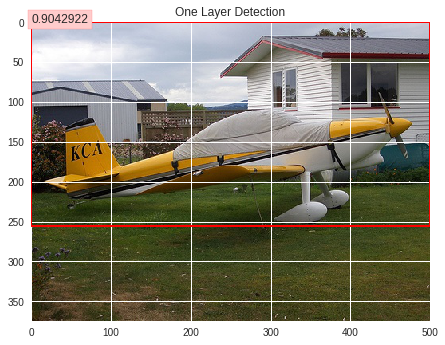

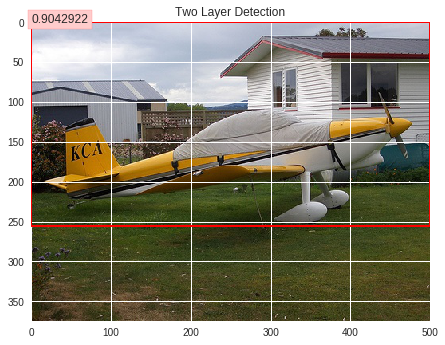

In [0]:
fname='001433'
print('aeroplane (red BB), bottle (green BB), chair (blue BB)')
compare_detector(fname)

aeroplane (red BB), bottle (green BB), chair (blue BB)
52.60093426704407 secs.


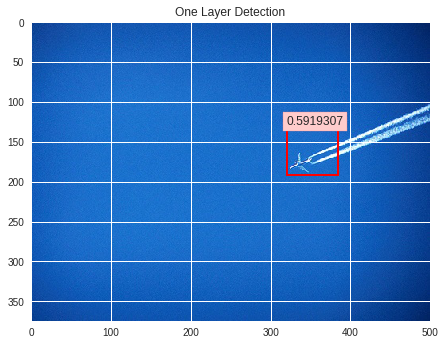

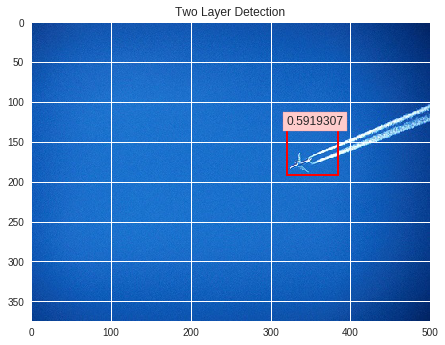

In [0]:
fname='001505'
print('aeroplane (red BB), bottle (green BB), chair (blue BB)')
compare_detector(fname)

aeroplane (red BB), bottle (green BB), chair (blue BB)
52.453502893447876 secs.


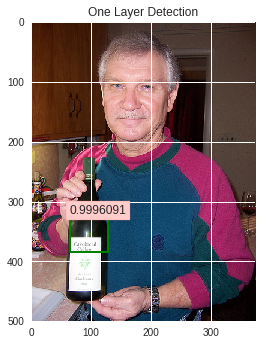

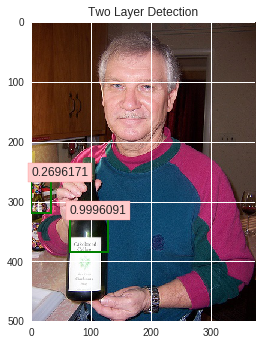

In [0]:
fname='003431'
print('aeroplane (red BB), bottle (green BB), chair (blue BB)')
compare_detector(fname)

aeroplane (red BB), bottle (green BB), chair (blue BB)
47.906920194625854 secs.


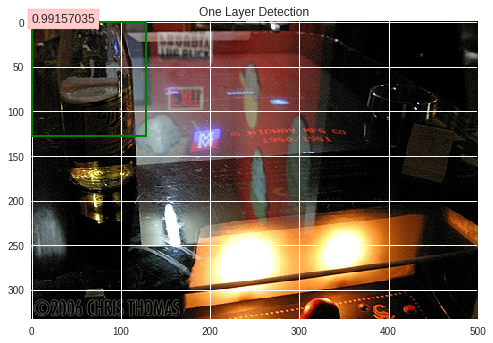

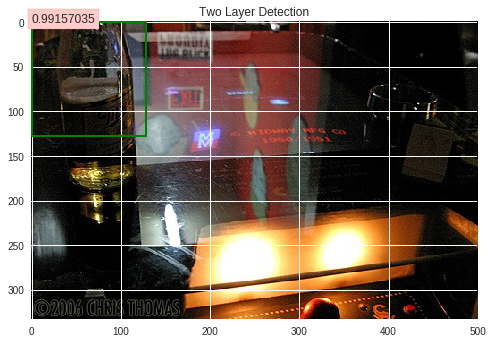

In [0]:
fname='009891'
print('aeroplane (red BB), bottle (green BB), chair (blue BB)')
compare_detector(fname)

aeroplane (red BB), bottle (green BB), chair (blue BB)
47.88889265060425 secs.


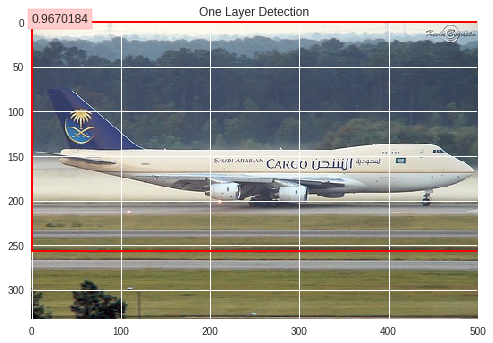

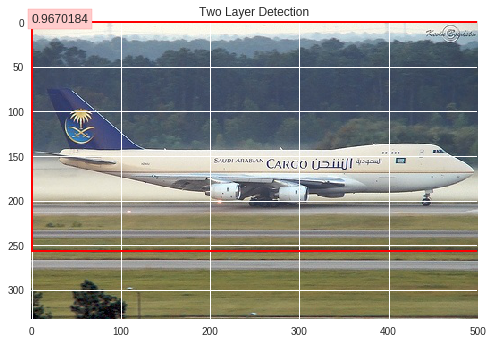

In [0]:
fname='004199'
print('aeroplane (red BB), bottle (green BB), chair (blue BB)')
compare_detector(fname)

aeroplane (red BB), bottle (green BB), chair (blue BB)
51.5944082736969 secs.


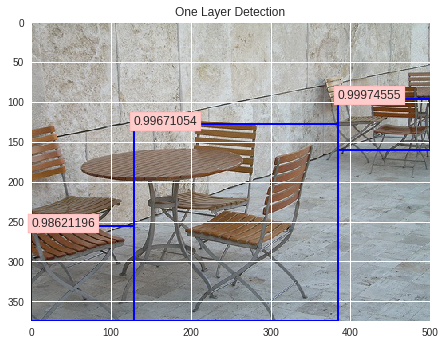

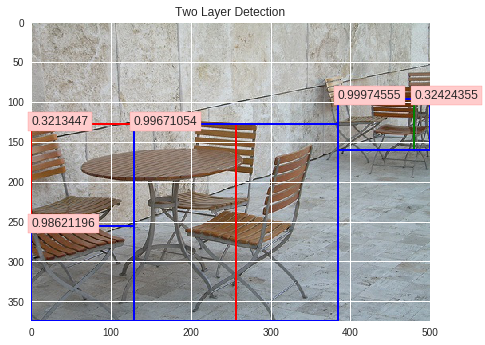

In [0]:
fname='001990'
print('aeroplane (red BB), bottle (green BB), chair (blue BB)')
compare_detector(fname)

# **Incorrect predictions**

aeroplane (red BB), bottle (green BB), chair (blue BB)
52.913816928863525 secs.


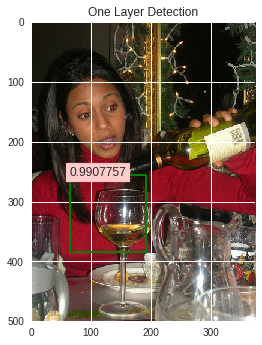

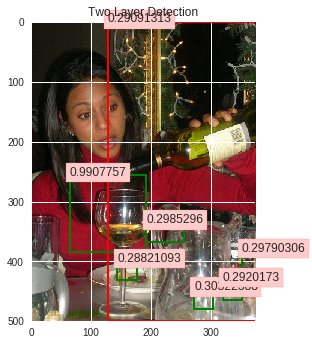

In [0]:
fname='000151'
print('aeroplane (red BB), bottle (green BB), chair (blue BB)')
compare_detector(fname)

aeroplane (red BB), bottle (green BB), chair (blue BB)
51.59782910346985 secs.


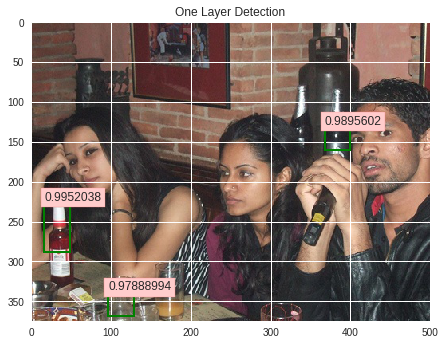

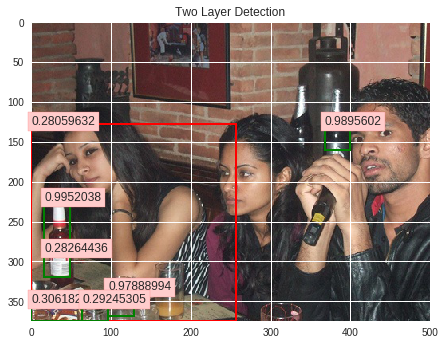

In [0]:
fname='004476'
print('aeroplane (red BB), bottle (green BB), chair (blue BB)')
compare_detector(fname)

aeroplane (red BB), bottle (green BB), chair (blue BB)
47.9673957824707 secs.


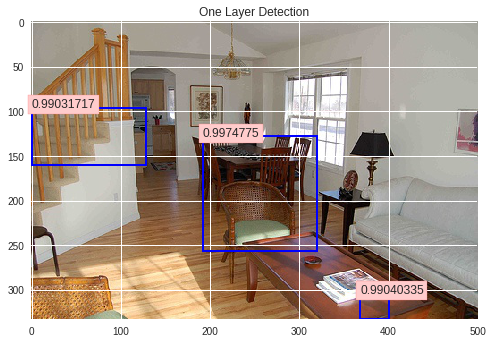

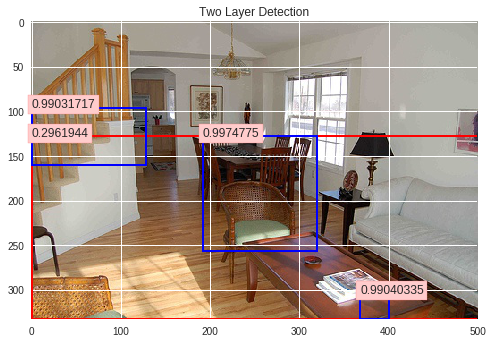

In [0]:
fname='000314'
print('aeroplane (red BB), bottle (green BB), chair (blue BB)')
compare_detector(fname)

aeroplane (red BB), bottle (green BB), chair (blue BB)
47.782105445861816 secs.


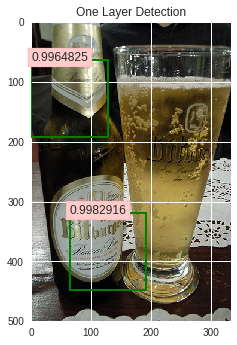

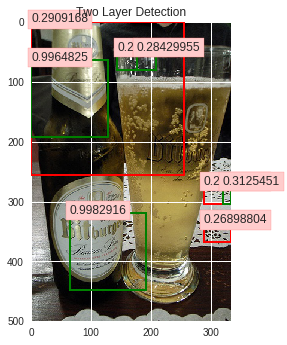

In [0]:
fname='009366'
print('aeroplane (red BB), bottle (green BB), chair (blue BB)')
compare_detector(fname)

aeroplane (red BB), bottle (green BB), chair (blue BB)
51.819711685180664 secs.


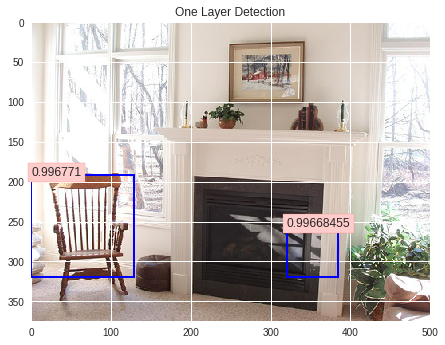

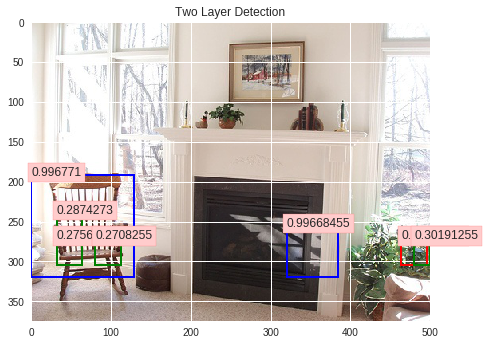

In [0]:
fname='000953'
print('aeroplane (red BB), bottle (green BB), chair (blue BB)')
compare_detector(fname)

# **Accuracy Calculation**
Model 1

In [0]:
import json
#Function to run first detector on an image and save predictions in json format
def gen_pred_json(fname):
  img = Image.open('VOCdevkit/VOC2007/JPEGImages/'+str(fname)+'.jpg')
  boxPredList4,boxPredList5,boxPredList6=pred_obj1(img)#model 1 detection  
  p1,p2,p3,pick1,pick2,pick3=nms_classwise(img,boxPredList4,boxPredList5,boxPredList6)#classwise NMS
#   print(p1)
  outList=[]
  if len(pick1)>0:
    for p,pick in zip(p1,pick1):    
      data = {}
#       print(p)
      data['label'] = 'aeroplane'
      data['confidence'] = str(p)  
      data['topleft'] = {'x': str(pick[0]),'y': str(pick[1]),}  
      data['bottomright'] = {'x': str(pick[2]),'y': str(pick[3]),}  
      outList.append(data)

  if len(pick2)>0:
    for p,pick in zip(p2,pick2):    
      data = {}  
      data['label'] = 'bottle'
      data['confidence'] = str(p)  
      data['topleft'] = {'x': str(pick[0]),'y': str(pick[1]),}  
      data['bottomright'] = {'x': str(pick[2]),'y': str(pick[3]),}  
      outList.append(data)

  if len(pick3)>0:
    for p,pick in zip(p3,pick3):    
      data = {}  
      data['label'] = 'chair'
      data['confidence'] = str(p)  
      data['topleft'] = {'x': str(pick[0]),'y': str(pick[1]),}  
      data['bottomright'] = {'x': str(pick[2]),'y': str(pick[3]),}  
      outList.append(data)    

  with open('predicted/'+fname+'.json', 'w') as outfile:  
      json.dump(outList, outfile)

import time
stime=time.time()
fname='004199'
gen_pred_json(fname) 
print(str(time.time()-stime)+' seconds.')

2.1136298179626465 seconds.


In [0]:
# Function to run first detector on entire test dataset and store results in json format in predicted/ folder
def pred_test_dataset():
  xmlfilesdata = np.loadtxt('VOCdevkit/VOC2007/ImageSets/Main/aeroplane_test.txt',dtype='str')
  id = (xmlfilesdata[:,1].astype(np.int))
  xmlfiles1 = xmlfilesdata[np.where(id>=1),0][0]
  xmlfilesdata = np.loadtxt('VOCdevkit/VOC2007/ImageSets/Main/bottle_test.txt',dtype='str')
  id = (xmlfilesdata[:,1].astype(np.int))
  xmlfiles2 = xmlfilesdata[np.where(id>=1),0][0]
  xmlfilesdata = np.loadtxt('VOCdevkit/VOC2007/ImageSets/Main/chair_test.txt',dtype='str')
  id = (xmlfilesdata[:,1].astype(np.int))
  xmlfiles3 = xmlfilesdata[np.where(id>=1),0][0]
  xmlfiles = np.concatenate((xmlfiles1,xmlfiles2,xmlfiles3))
  
  for c_dirs in ['predicted','ground_truth']:
    try:
      os.makedirs(c_dirs)
    except:
      print('directory {} already exists'.format(c_dirs))      
  
  for fname in xmlfiles:
#     src='VOCdevkit/VOC2007/Annotations/'+str(fname)+'.xml'
#     dst='ground_truth/'+str(fname)+'.xml'
#     copyfile(src, dst)      
    gen_pred_json(fname) 
  
from shutil import copyfile
pred_test_dataset()

directory predicted already exists
directory ground_truth already exists


In [0]:
!python mAP.py

Clean the previous data
0.00%  sofa AP
0.14%  chair AP
0.00%  pottedplant AP
0.00%  diningtable AP
5.16%  aeroplane AP
0.00%  person AP
0.12%  bottle AP
0.00%  cat AP
0.00%  tvmonitor AP
0.00%  dog AP
0.00%  horse AP
0.00%  bird AP
0.00%  bicycle AP
0.00%  car AP
0.00%  bus AP
0.00%  boat AP
0.00%  sheep AP
0.00%  motorbike AP
0.30%  mAP


Model 2

In [0]:
import json
#Function to run second detector on an image and save predictions in json format

def gen_pred2_json(fname):
  img = Image.open('VOCdevkit/VOC2007/JPEGImages/'+str(fname)+'.jpg')
  boxPredList1,boxPredList2,boxPredList3=pred_obj1(img)#model 1 detection  
  boxPredList4,boxPredList5,boxPredList6=pred_obj2(img)  
  #merge bounding boxes of the two 
  boxPredList7=boxPredList1+boxPredList4
  boxPredList8=boxPredList2+boxPredList5
  boxPredList9=boxPredList3+boxPredList6
  p1,p2,p3,pick1,pick2,pick3=nms_classwise(img,boxPredList7,boxPredList8,boxPredList9)
  
#   print(p1)
  outList=[]
  if len(pick1)>0:
    for p,pick in zip(p1,pick1):    
      data = {}
#       print(p)
      data['label'] = 'aeroplane'
      data['confidence'] = str(p)  
      data['topleft'] = {'x': str(pick[0]),'y': str(pick[1]),}  
      data['bottomright'] = {'x': str(pick[2]),'y': str(pick[3]),}  
      outList.append(data)

  if len(pick2)>0:
    for p,pick in zip(p2,pick2):    
      data = {}  
      data['label'] = 'bottle'
      data['confidence'] = str(p)  
      data['topleft'] = {'x': str(pick[0]),'y': str(pick[1]),}  
      data['bottomright'] = {'x': str(pick[2]),'y': str(pick[3]),}  
      outList.append(data)

  if len(pick3)>0:
    for p,pick in zip(p3,pick3):    
      data = {}  
      data['label'] = 'chair'
      data['confidence'] = str(p)  
      data['topleft'] = {'x': str(pick[0]),'y': str(pick[1]),}  
      data['bottomright'] = {'x': str(pick[2]),'y': str(pick[3]),}  
      outList.append(data)    

  with open('predicted2/'+fname+'.json', 'w') as outfile:  
      json.dump(outList, outfile)

import time
stime=time.time()
fname='004199'
gen_pred2_json(fname) 
print(str(time.time()-stime)+' seconds.')

3.698323965072632 seconds.


In [0]:
# Function to run first detector on entire test dataset and store results in json format in predicted/ folder
def pred2_test_dataset():
  xmlfilesdata = np.loadtxt('VOCdevkit/VOC2007/ImageSets/Main/aeroplane_test.txt',dtype='str')
  id = (xmlfilesdata[:,1].astype(np.int))
  xmlfiles1 = xmlfilesdata[np.where(id>=1),0][0]
  xmlfilesdata = np.loadtxt('VOCdevkit/VOC2007/ImageSets/Main/bottle_test.txt',dtype='str')
  id = (xmlfilesdata[:,1].astype(np.int))
  xmlfiles2 = xmlfilesdata[np.where(id>=1),0][0]
  xmlfilesdata = np.loadtxt('VOCdevkit/VOC2007/ImageSets/Main/chair_test.txt',dtype='str')
  id = (xmlfilesdata[:,1].astype(np.int))
  xmlfiles3 = xmlfilesdata[np.where(id>=1),0][0]
  xmlfiles = np.concatenate((xmlfiles1,xmlfiles2,xmlfiles3))
  
  for c_dirs in ['predicted2','ground_truth']:
    try:
      os.makedirs(c_dirs)
    except:
      print('directory {} already exists'.format(c_dirs))      
  
  for fname in xmlfiles:
#     src='VOCdevkit/VOC2007/Annotations/'+str(fname)+'.xml'
#     dst='ground_truth/'+str(fname)+'.xml'
#     copyfile(src, dst)      
    gen_pred_json(fname) 
  
from shutil import copyfile
pred2_test_dataset()

directory predicted2 already exists
directory ground_truth already exists


In [0]:
!python mAP2.py

Clean the previous data
0.00%  sofa AP
0.15%  chair AP
0.00%  pottedplant AP
0.00%  diningtable AP
5.94%  aeroplane AP
0.00%  person AP
0.12%  bottle AP
0.00%  cat AP
0.00%  tvmonitor AP
0.00%  dog AP
0.00%  horse AP
0.00%  bird AP
0.00%  bicycle AP
0.00%  car AP
0.00%  bus AP
0.00%  boat AP
0.00%  sheep AP
0.00%  motorbike AP
0.35%  mAP


# **Rough**

### Fine-tuning model 3


In [0]:
import torch.nn as nn
import torch
class resnet_2(nn.Module):
  def __init__(self):
    super(resnet_2,self).__init__()
    resnet18 = torch.load('model/resnetFCnLastmodel')
    #resnet18 = models.resnet18(pretrained=True)
    child = []
    for i in resnet18.children():
      child.append(i)
    self.Conv1 = child[0] # 3->64
    self.bn1 = child[1]
    self.relu = child[2]
    self.maxpool = child[3]
    self.basic1 = child[4] # 64->64
    self.basic2 = child[5] # 64->128
    self.basic3 = child[6] # 128->256
    self.avgpool2 = nn.AdaptiveAvgPool2d((2, 1))
    self.avgpool1 = nn.AdaptiveAvgPool2d((2, 2))
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc1 = nn.Linear(768 , 256,bias=True)
    self.fc2 = nn.Linear(256 , 4,bias=True)

  def forward(self,x):
    x = self.Conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.basic1(x)
    out1 = self.avgpool1(x)
    out1 = out1.view(out1.size(0), -1)
    x = self.basic2(x)
    out2 = self.avgpool2(x)
    out2 = out2.view(out2.size(0), -1)
    x = self.basic3(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = torch.cat([out1, out2,x],1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x
resnet_123layer=resnet_2()

In [0]:
ct = 0
for child in resnet_123layer.children():
  ct += 1
  if (ct > 10):
    print(child)
    for param in child.parameters():
      param.requires_grad = True

Linear(in_features=768, out_features=256, bias=True)
Linear(in_features=256, out_features=4, bias=True)


In [0]:
# Send the model to GPU
resnet_123layer = resnet_123layer.to(device)
feature_extract = False
params_to_update = resnet_123layer.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in resnet_123layer.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in resnet_123layer.named_parameters():
        if param.requires_grad == True:
          print("\t",name)

# Observe that all parameters are being optimized
#optimizer = optim.SGD(params_to_update, learning_rate=0.001, momentum=0.9)
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()


Params to learn:
	 fc1.weight
	 fc1.bias
	 fc2.weight
	 fc2.bias


In [0]:
import copy
# Train and evaluate
model_name = "resnet"
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# resnet182 = torch.load('model/resnetFCnLastmodel')
resnet2, hist = train_model(resnet2, dataloaders_dict, criterion, optimizer_ft, num_epochs=150)

In [0]:
#save the model
c_dirs='model'
try:
  os.makedirs(c_dirs)
except:
  print('directory {} already exists'.format(c_dirs))
torch.save(resnet2, 'model/resnet_123layer')

directory model already exists


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type resnet_2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
